# Common Test I. Multi-Class Classification


In [1]:
import random
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as T
from torch import Tensor, nn, optim
from torch.utils.data import DataLoader, Dataset
from torchmetrics import AUROC, Accuracy, ROC
from tqdm import tqdm

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

## Dataset Preprocessing

Download the dataset from Google Drive and uncompress.

In [3]:
!pip install -q gdown
!gdown 1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ
!unzip -q dataset.zip dataset/*

Downloading...
From (original): https://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ
From (redirected): https://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ&confirm=t&uuid=d1df609d-6fd7-4f9d-8433-b154944e9ce5
To: /kaggle/working/dataset.zip
100%|██████████████████████████████████████| 1.13G/1.13G [00:13<00:00, 84.1MB/s]


Build train/validation datasets using PyTorch interfaces.

In [4]:
class LenseImageDataset(Dataset):
    classes = ['no', 'sphere', 'vort']

    def __init__(self, phase: str) -> None:
        # paths to data files
        self.data = [
            (f'dataset/{phase}/{class_}/{idx + 1}.npy', label)
            for label, class_ in enumerate(self.classes)
            for idx in range(10000 if phase == 'train' else 2500)
        ]
        random.shuffle(self.data)
        # train/val data transformation
        # use histogram equalization to enhance contrast
        if phase == 'train':
            self.transform = T.Compose([
                T.RandomVerticalFlip(),
                T.RandomHorizontalFlip(),
                T.RandomEqualize(1.0)
            ])
        else:
            self.transform = T.RandomEqualize(1.0)
        

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[Tensor, int]:
        path, label = self.data[idx]
        image = torch.from_numpy(np.load(path).astype(np.float32))
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
train_set    = LenseImageDataset('train')
val_set      = LenseImageDataset('val')
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=64, shuffle=False)

Visualize several images from each class of the dataset.

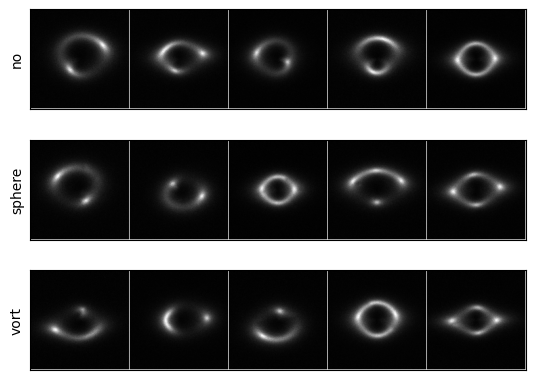

In [6]:
for i, class_ in enumerate(LenseImageDataset.classes):
    images = torchvision.utils.make_grid(
        [
            torch.from_numpy(np.load(f'dataset/train/{class_}/{j + 1}.npy'))
            for j in range(5)
        ],
        padding=1,
        pad_value=1
    ).permute(1, 2, 0).numpy()
    plt.subplot(3, 1, i + 1)
    plt.imshow(images)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(class_)

## Model Training

Use pretrained ResNet-18 for transfer learning.

In [7]:
model = timm.create_model('resnet18', pretrained=True, in_chans=1, num_classes=3)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

cuda:0


Use cross entropy loss (with L2 regularization), Adam optimizer, and learning rate decay.

In [9]:
lossfn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

Finetune ResNet-18 using 10 epochs, save the model with best accuracy.

In [10]:
n_epochs = 10
best_score = 0

for epoch in range(n_epochs):
    # train
    model.train()
    for X, y in tqdm(train_loader):
        X, y = X.to(device), y.to(device)
        loss = lossfn(model(X), y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
    # validation
    model.eval()
    acc = Accuracy(task='multiclass', num_classes=3).to(device)
    for X, y in tqdm(val_loader):
        X, y = X.to(device), y.to(device)
        acc.update(model(X), y)
    score = acc.compute()
    print(f'Epoch {epoch + 1} - Accuracy (validation) {score}')
    if score > best_score:
        best_score = score
        torch.save(model.state_dict(), 'model.pth')

100%|██████████| 118/118 [00:09<00:00, 12.96it/s]


Epoch 1 - Accuracy (validation) 0.4349333345890045


100%|██████████| 118/118 [00:09<00:00, 13.08it/s]


Epoch 2 - Accuracy (validation) 0.47333332896232605


100%|██████████| 118/118 [00:08<00:00, 13.43it/s]


Epoch 3 - Accuracy (validation) 0.675599992275238


100%|██████████| 118/118 [00:08<00:00, 13.83it/s]


Epoch 4 - Accuracy (validation) 0.7309333086013794


100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch 5 - Accuracy (validation) 0.8004000186920166


100%|██████████| 118/118 [00:08<00:00, 13.61it/s]


Epoch 6 - Accuracy (validation) 0.8094666600227356


100%|██████████| 118/118 [00:08<00:00, 13.60it/s]


Epoch 7 - Accuracy (validation) 0.8127999901771545


100%|██████████| 118/118 [00:08<00:00, 13.58it/s]


Epoch 8 - Accuracy (validation) 0.8127999901771545


100%|██████████| 118/118 [00:08<00:00, 13.88it/s]


Epoch 9 - Accuracy (validation) 0.8140000104904175


100%|██████████| 118/118 [00:08<00:00, 13.42it/s]

Epoch 10 - Accuracy (validation) 0.8127999901771545


# Metrics

Compute AUROC metric for train/validation datasets.

In [14]:
auroc = AUROC(task='multiclass', num_classes=3)
for X, y in tqdm(train_loader):
    X, y = X.to(device), y.to(device)
    auroc.update(model(X), y)
print(f'AUROC (train): {auroc.compute()}')

100%|██████████| 469/469 [00:37<00:00, 12.53it/s]

AUROC (train): 0.9468891620635986


In [15]:
auroc = AUROC(task='multiclass', num_classes=3)
for X, y in tqdm(val_loader):
    X, y = X.to(device), y.to(device)
    auroc.update(model(X), y)
print(f'AUROC (validation): {auroc.compute()}')

100%|██████████| 118/118 [00:08<00:00, 13.46it/s]

AUROC (validation): 0.9406577944755554


Plot the ROC curve for the validation dataset.

100%|██████████| 118/118 [00:08<00:00, 13.61it/s]


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MulticlassROC'}, xlabel='False positive rate', ylabel='True positive rate'>)

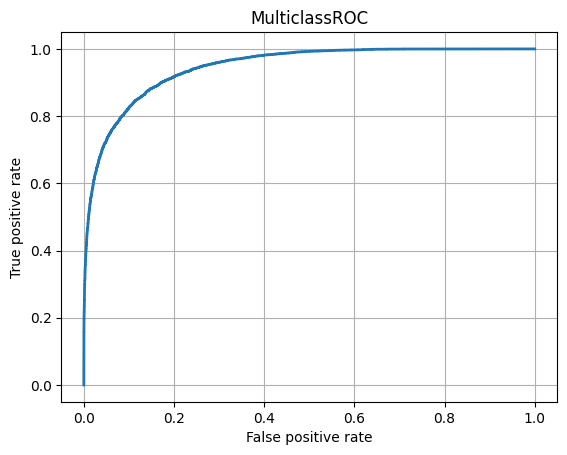

In [16]:
roc = ROC(task='multiclass', num_classes=3, average='micro')
for X, y in tqdm(val_loader):
    X, y = X.to(device), y.to(device)
    roc.update(model(X), y)
roc.plot(roc.compute())